In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa import stl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import yfinance as yf
from warnings import filterwarnings
filterwarnings("ignore")

In [63]:
df = yf.download('MSFT', start='2015-01-01', group_by='column')

[*********************100%***********************]  1 of 1 completed


In [64]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2015-01-02,39.998695,40.563262,39.810509,39.913156,27913900
2015-01-05,39.630886,39.973046,39.562452,39.665100,39673900
2015-01-06,39.049194,39.990137,38.955099,39.673639,36447900
2015-01-07,39.545338,39.742080,38.912340,39.331487,29114100
2015-01-08,40.708691,40.845555,39.964490,39.990151,29645200


In [65]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2025-06-02,461.970001,462.109985,456.890015,457.140015,16626500
2025-06-03,462.970001,464.140015,460.859985,461.470001,15743800
2025-06-04,463.869995,465.690002,463.019989,464.000000,14162700
2025-06-05,467.679993,469.649994,464.029999,464.959991,20154500
2025-06-06,470.380005,473.339996,468.779999,470.089996,15278600


In [66]:
# Flatten the columns by keeping only the second level (i.e., drop 'Price')
df.columns = df.columns.droplevel(1)

In [67]:
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,39.998695,40.563262,39.810509,39.913156,27913900
2015-01-05,39.630886,39.973046,39.562452,39.665100,39673900
2015-01-06,39.049194,39.990137,38.955099,39.673639,36447900
2015-01-07,39.545338,39.742080,38.912340,39.331487,29114100
2015-01-08,40.708691,40.845555,39.964490,39.990151,29645200


In [68]:
# df.to_excel('Microsoft.xlsx')

In [69]:
stock_data = pd.DataFrame(df['Close'],columns=['Close'])

In [70]:
stock_data.head()

,Close
Date,
2015-01-02,39.998695
2015-01-05,39.630886
2015-01-06,39.049194
2015-01-07,39.545338
2015-01-08,40.708691


# Data cleaning ,Data visualization and EDA 

In [71]:
#Summary statistics
stock_data.describe()

,Close
count,2623.000000
mean,190.707402
std,129.294311
min,34.558342
25%,66.878780
50%,162.584610
75%,287.702637
max,470.380005


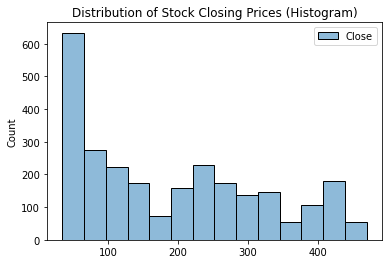

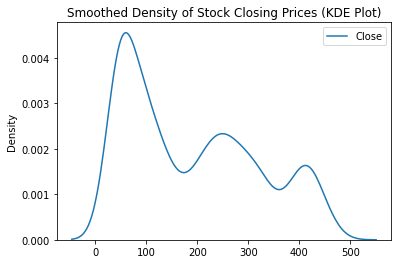

In [72]:
#Visualizations
plt.title('Distribution of Stock Closing Prices (Histogram)')
sns.histplot(stock_data)
plt.show()

plt.title('Smoothed Density of Stock Closing Prices (KDE Plot)')
sns.kdeplot(stock_data)
plt.show()

In [73]:
# Time series decomposition (multiplicative model)
result = seasonal_decompose(stock_data, model='multiplicative', period=365)

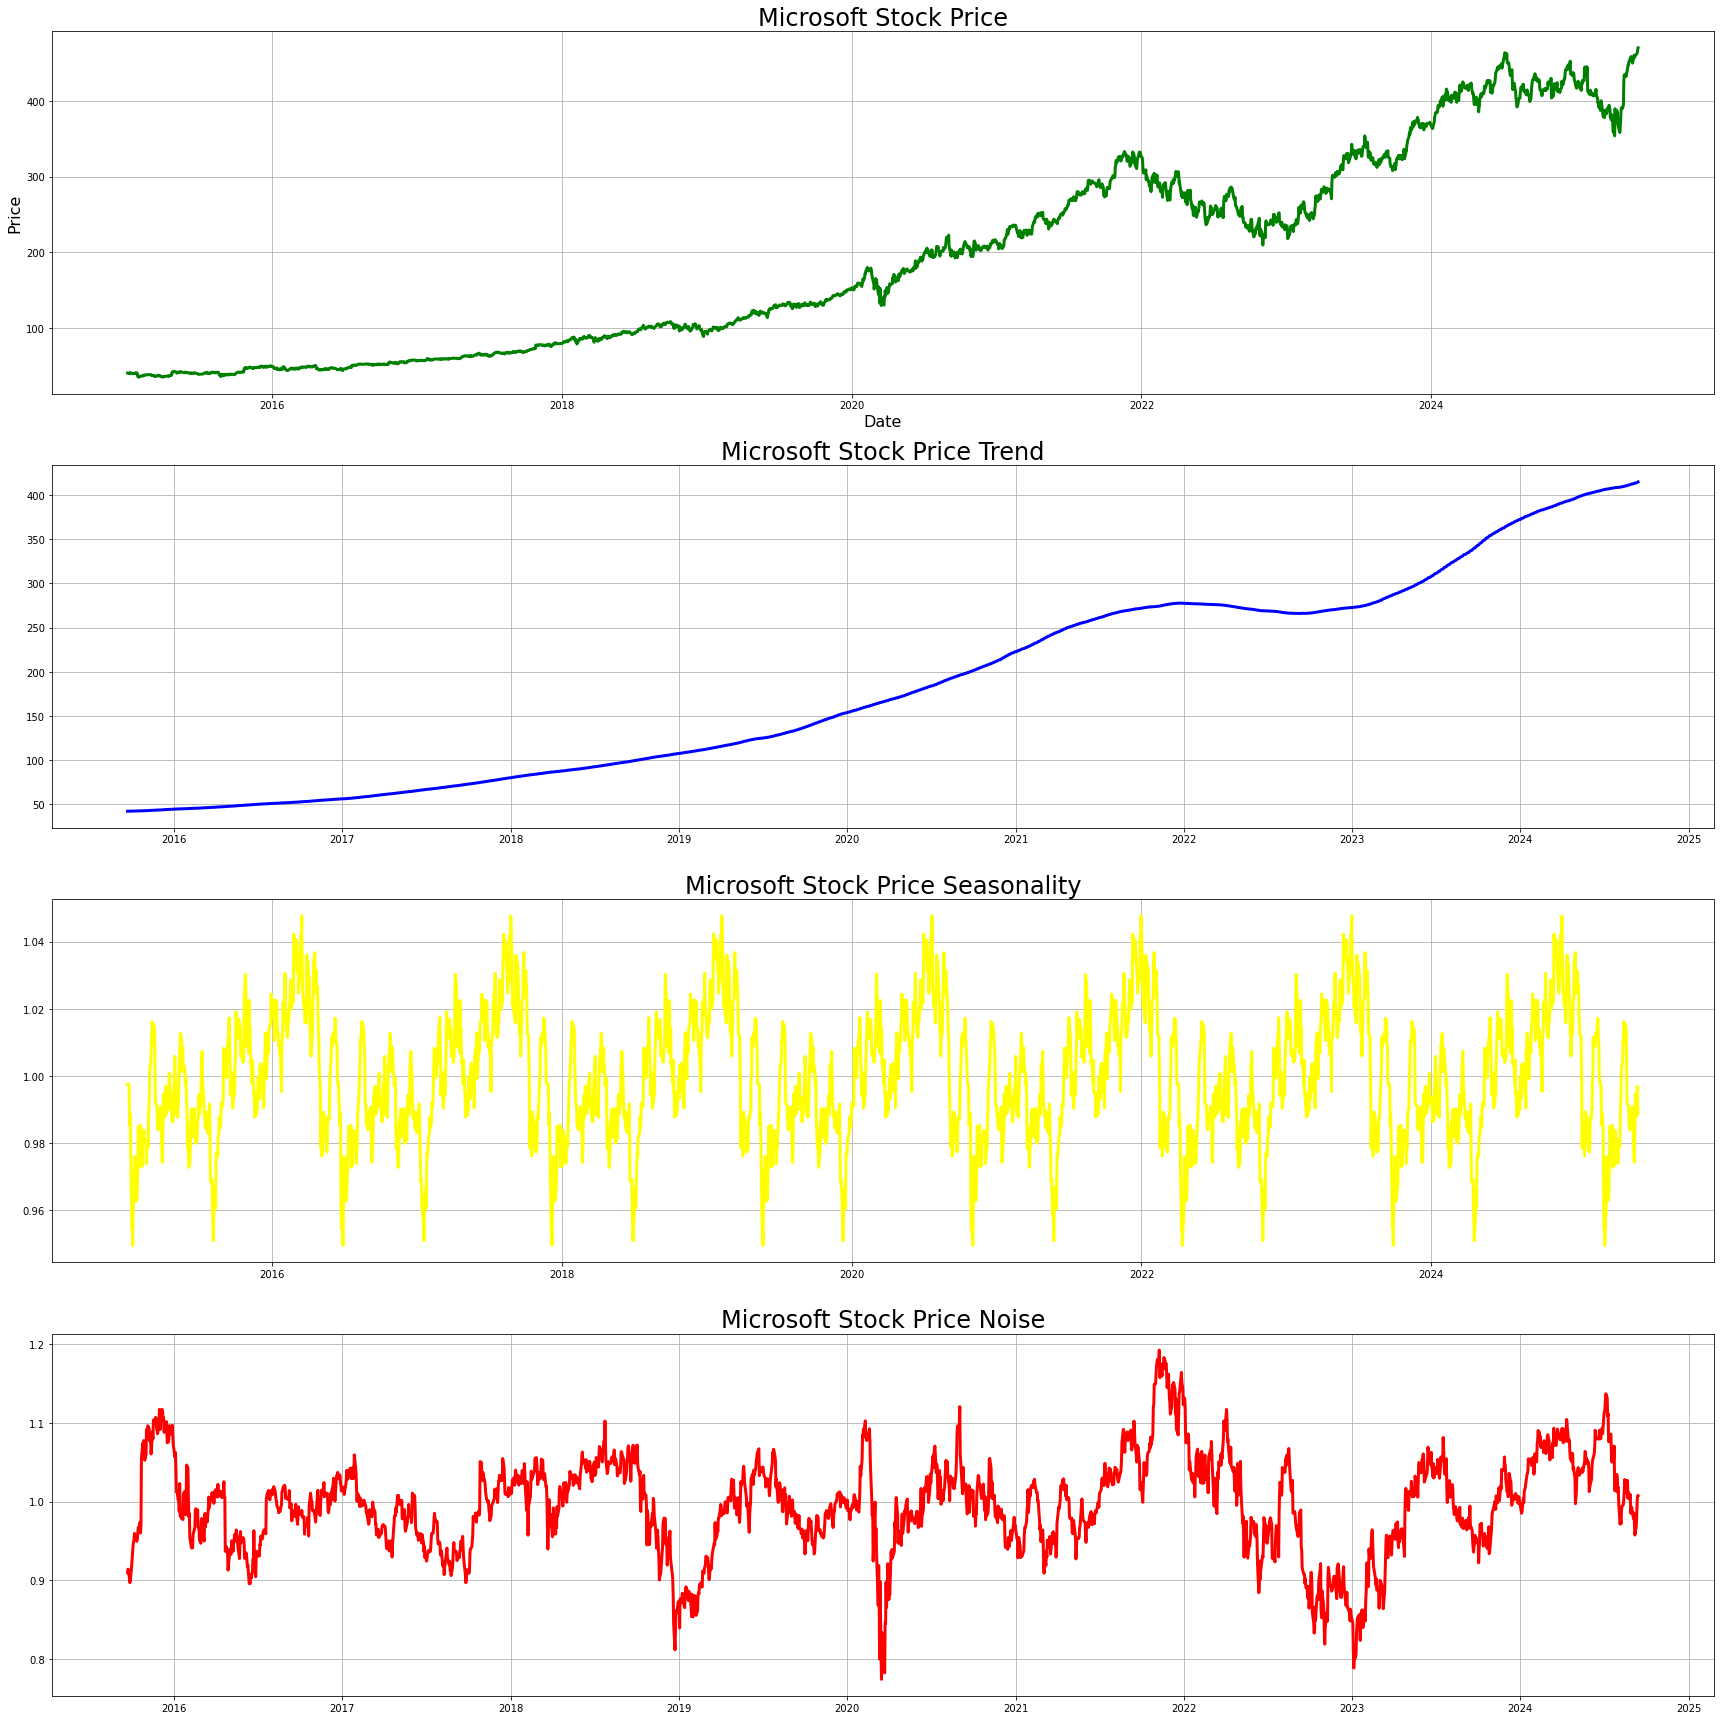

In [74]:
#Visualizing the decomposition
plt.figure(figsize=(24,24))

plt.subplot(4,1,1)
plt.plot(stock_data,color = 'green',linewidth = 3)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.title('Microsoft Stock Price',fontsize=24)
plt.grid()

plt.subplot(4,1,2)
plt.plot(result.trend,color = 'Blue',linewidth = 3)
plt.title('Microsoft Stock Price Trend',fontsize=24)
plt.grid()

plt.subplot(4,1,3)
plt.plot(result.seasonal,color = 'Yellow',linewidth = 3)
plt.title('Microsoft Stock Price Seasonality',fontsize=24)
plt.grid()

plt.subplot(4,1,4)
plt.plot(result.resid,color = 'Red',linewidth = 3)
plt.title('Microsoft Stock Price Noise',fontsize=24)
plt.grid()

plt.tight_layout()
plt.show()

In [75]:
# Time series decomposition (Additive model)
result = seasonal_decompose(stock_data, model='additive', period=365)

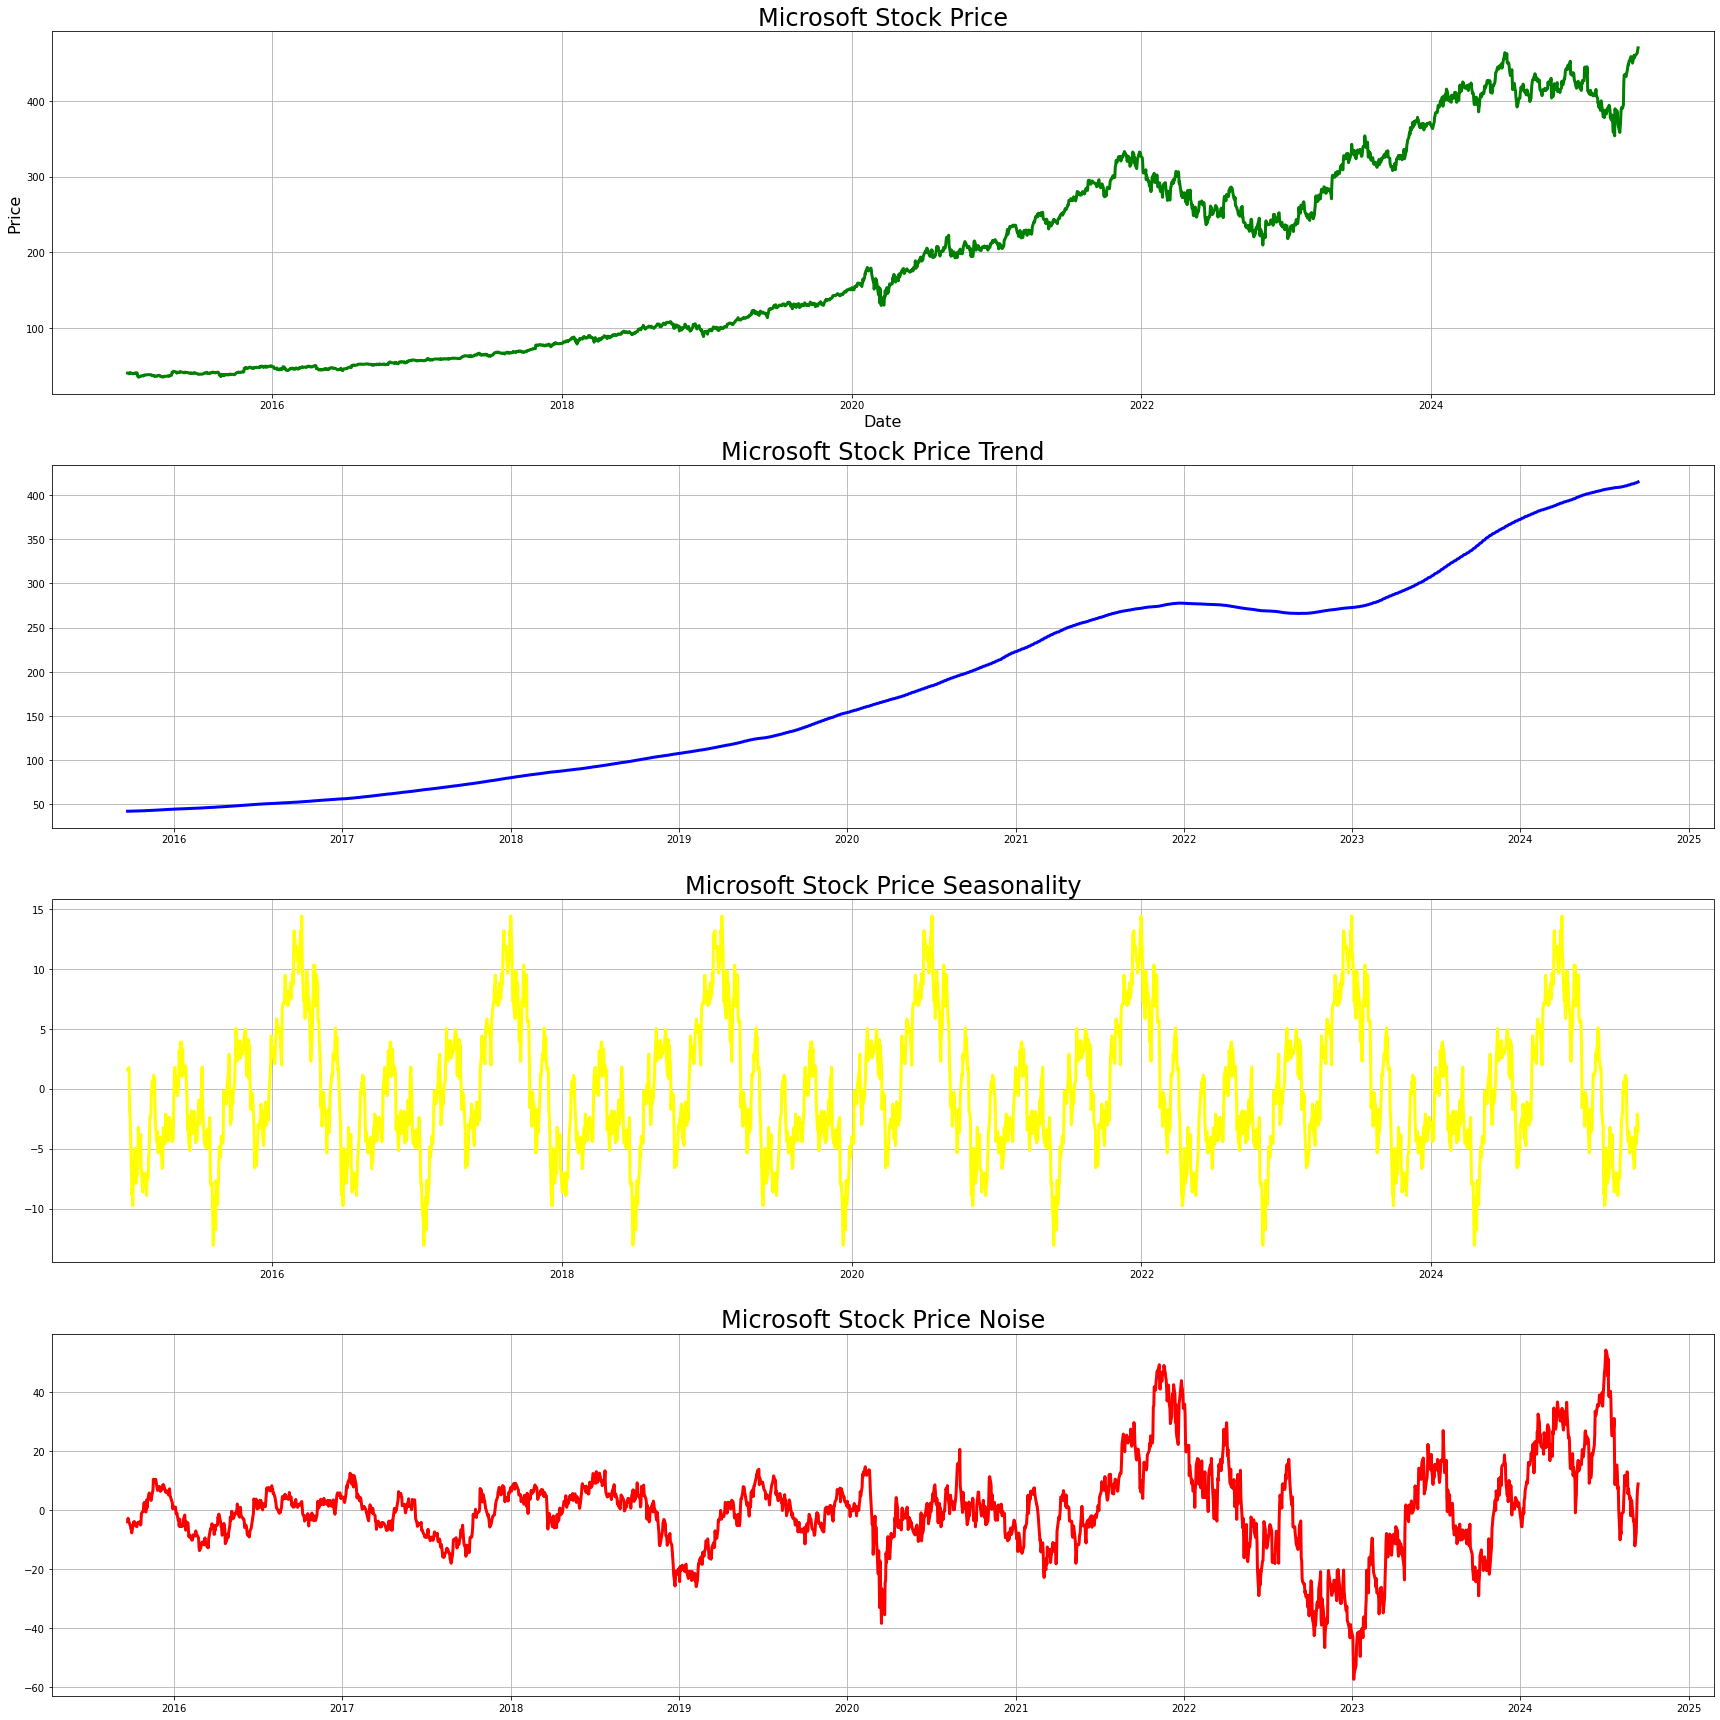

In [76]:
#Visualizing the decomposition
plt.figure(figsize=(24,24))

plt.subplot(4,1,1)
plt.plot(stock_data,color = 'green',linewidth = 3)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.title('Microsoft Stock Price',fontsize=24)
plt.grid()

plt.subplot(4,1,2)
plt.plot(result.trend,color = 'Blue',linewidth = 3)
plt.title('Microsoft Stock Price Trend',fontsize=24)
plt.grid()

plt.subplot(4,1,3)
plt.plot(result.seasonal,color = 'Yellow',linewidth = 3)
plt.title('Microsoft Stock Price Seasonality',fontsize=24)
plt.grid()

plt.subplot(4,1,4)
plt.plot(result.resid,color = 'Red',linewidth = 3)
plt.title('Microsoft Stock Price Noise',fontsize=24)
plt.grid()

plt.tight_layout()
plt.show()

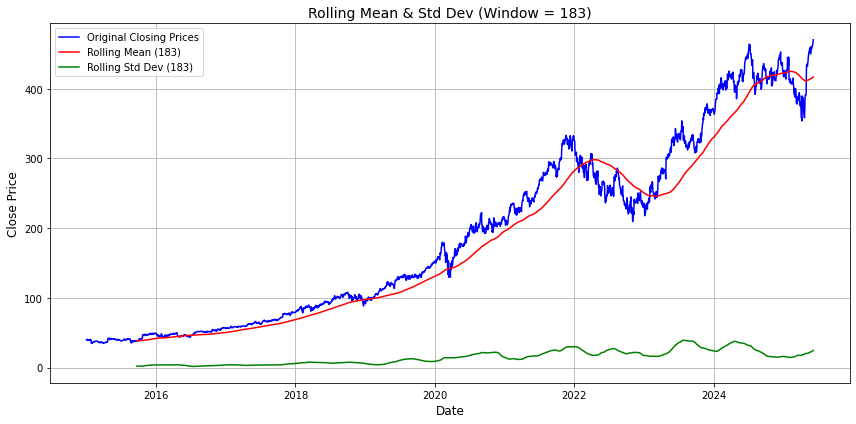

In [77]:
# Rolling mean and standard deviation
window_size = 183
rolling_mean = stock_data['Close'].rolling(window=window_size).mean()
rolling_std = stock_data['Close'].rolling(window=window_size).std()


plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Original Closing Prices', color='blue')
plt.plot(rolling_mean, label=f'Rolling Mean ({window_size})', color='red')
plt.plot(rolling_std, label=f'Rolling Std Dev ({window_size})', color='green')


plt.title(f'Rolling Mean & Std Dev (Window = {window_size})', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [78]:
# Stationarity Check

def Adf_test(data,alpha=0.05):
    val = adfuller(data)[1]
    if val > alpha:
        print(f'P-value is {val.round(4)} which is more than {alpha} therefore data is  Non - Stationary ❌')
    else:
        print(f'P-value is {val.round(4)} which is less than {alpha} therefore data Stationary ✅' )

In [79]:
Adf_test(stock_data)

P-value is 0.9866 which is more than 0.05 therefore data is  Non - Stationary ❌


In [80]:
# Visualizations also suggest that data is non-stationary
# Let's check if first differntiation makes any changes
# stock_data.head().diff().dropna()

Adf_test(stock_data.diff().dropna())

# After doing the first differentation the data becomes stationary

P-value is 0.0 which is less than 0.05 therefore data Stationary ✅


In [81]:
# I am conduction another test for stationarity just to be sure.

def Kpss_test(data,alpha=0.05):
    val = kpss(data)[1]
    if val > alpha:
        print('Stationary ✅')
    else:
        print('Non - Stationary ❌')
        
Kpss_test(stock_data)
Kpss_test(stock_data.diff().dropna())

Non - Stationary ❌
Stationary ✅


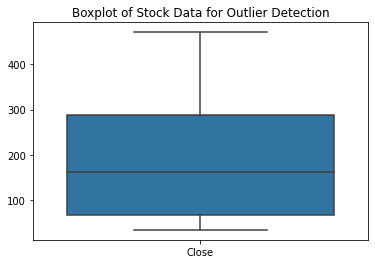

In [82]:
# Outlier detection
plt.title('Boxplot of Stock Data for Outlier Detection')
sns.boxplot(stock_data)
plt.show()

# Visualization shows that we don't have any outliers therefore we don't need to handle them

<Figure size 720x288 with 0 Axes>

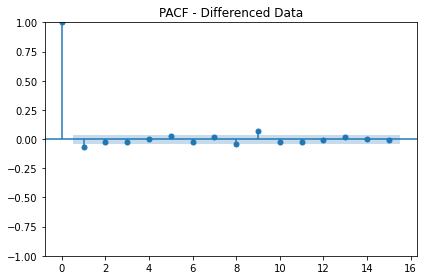

<Figure size 720x288 with 0 Axes>

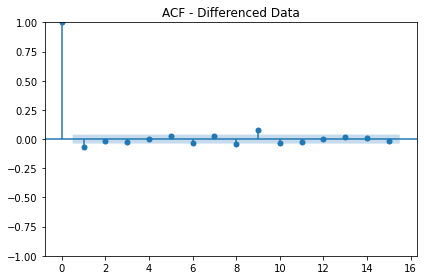

In [83]:
#Generating ACF and PACF plots

diff_data = stock_data.diff().dropna()

plt.figure(figsize=(10, 4))
plot_pacf(diff_data, lags=15)
plt.title("PACF - Differenced Data")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(diff_data, lags=15)
plt.title("ACF - Differenced Data")
plt.tight_layout()
plt.show()



<Figure size 720x288 with 0 Axes>

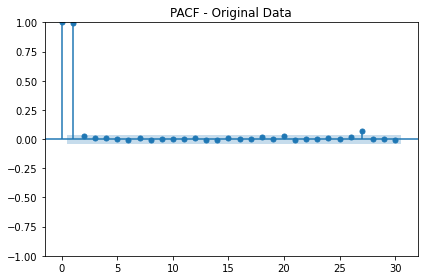

<Figure size 720x288 with 0 Axes>

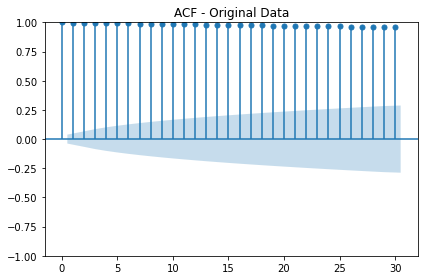

In [84]:
# --- PACF and ACF on Original Data (not recommended for ARIMA, just for comparison) ---
plt.figure(figsize=(10, 4))
plot_pacf(stock_data, lags=30)
plt.title("PACF - Original Data")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(stock_data, lags=30)
plt.title("ACF - Original Data")
plt.tight_layout()
plt.show()

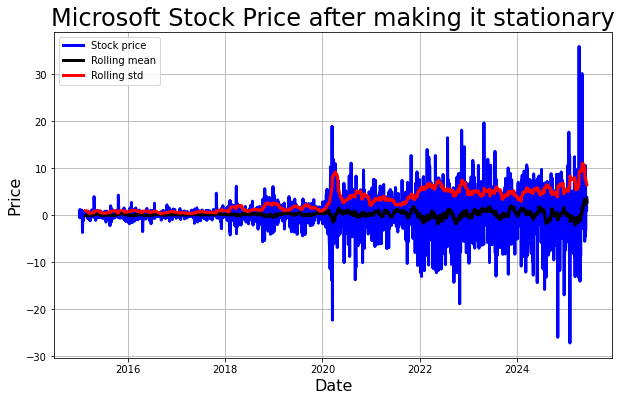

In [85]:
#Visualizing the decomposition
plt.figure(figsize=(10,6))

plt.plot(diff_data, color='blue', linewidth=3, label='Stock price')
plt.plot(diff_data.rolling(window=30).mean(), color='black', linewidth=3, label='Rolling mean')
plt.plot(diff_data.rolling(window=30).std(), color='red', linewidth=3, label='Rolling std')

plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title('Microsoft Stock Price after making it stationary', fontsize=24)
plt.grid()
plt.legend()
plt.show()


# Model building

In [86]:
# Splitting the data into training and testing sets
train_size = int(len(stock_data) * 0.8)
train_data = stock_data[:train_size]

test_data = stock_data[train_size:]

In [87]:
#Print the size
print(f'Shape of data {stock_data.shape}\nSize of training data {train_size}\nSize of testing Data {2621-2096}')


Shape of data (2623, 1)
Size of training data 2098
Size of testing Data 525


In [88]:
history = [x for x in train_data['Close']]

print(history)

[39.998695373535156, 39.63088607788086, 39.0491943359375, 39.54533767700195, 40.70869064331055, 40.36652755737305, 39.86183166503906, 39.65654754638672, 39.31436538696289, 38.90378189086914, 39.55390167236328, 39.68218994140625, 39.280147552490234, 40.315208435058594, 40.35796356201172, 40.21254348754883, 36.49154281616211, 35.23409652709961, 35.9355354309082, 34.55834197998047, 35.31106948852539, 35.584815979003906, 35.79011917114258, 36.311912536621094, 36.2776985168457, 36.23491668701172, 36.440223693847656, 36.25202941894531, 36.859371185302734, 37.52659225463867, 37.54381561279297, 37.500728607177734, 37.47489929199219, 37.78504180908203, 38.03486251831055, 37.9831657409668, 37.89703369140625, 37.95732116699219, 37.77641296386719, 37.802249908447266, 37.28535842895508, 37.09583282470703, 37.13890075683594, 36.492801666259766, 36.914920806884766, 36.20850372314453, 36.1654167175293, 35.3383903503418, 35.64852523803711, 35.8036003112793, 35.9242057800293, 36.613399505615234, 36.4324

# Arima Model

In [89]:
model = ARIMA(history,order=(1,1,1))
fit = model.fit()

In [ ]:
fit.summary()

In [91]:
result = fit.forecast(steps=525)

In [92]:
np.sqrt(mean_squared_error(test_data,result))

100.6171808268909

In [93]:
def train_arima_model(X, y, arima_order):
    history = [x for x in X]
    predictions = []

    for i in range(len(y)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.forecast()
        predictions.append(forecast[0])
        history.append(y[i])

    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse, predictions  


In [94]:
rmse_score, forecasted_values = train_arima_model(train_data['Close'], test_data['Close'], [1,1,1])

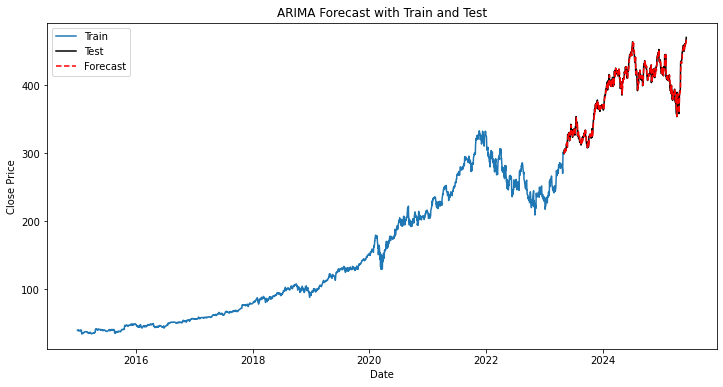

In [95]:
# Use the test_data index directly
forecast_series = pd.Series(forecasted_values, index=test_data.index)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data['Close'], label='Train')
plt.plot(test_data['Close'], label='Test', color='black')
plt.plot(forecast_series, label='Forecast', linestyle='--', color='red')
plt.legend()
plt.title('ARIMA Forecast with Train and Test')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


In [96]:
def evaluate_models(train_data, test_data, p_values, d_values, q_values):
    best_score, best_cfg = float('inf'), None

    print(f"Evaluating {len(p_values) * len(d_values) * len(q_values)} ARIMA models...")

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train_data, order=order)
                    model_fit = model.fit()
                    predictions = model_fit.predict(
                        start=len(train_data),
                        end=len(train_data) + len(test_data) - 1,
                        dynamic=True
                    )
                    if isinstance(test_data, pd.Series):
                        predictions.index = test_data.index
                        
                    rmse = np.sqrt(mean_squared_error(test_data, predictions))
                    print(f'ARIMA{order} RMSE: {round(rmse,4)}')
                    
                    if rmse < best_score:
                        best_score = rmse
                        best_cfg = order
                except:
                    continue
                
    print("\n--- Evaluation Complete ---")
    print(f'Best ARIMA{best_cfg} RMSE: {best_score:.4f}')

    return best_cfg

In [97]:
p = range(0,3)
d = range(0,3)
q = range(0,3)

Output= evaluate_models(train_data,test_data,p,d,q)

Evaluating 27 ARIMA models...
ARIMA(0, 0, 0) RMSE: 252.7494
ARIMA(0, 0, 1) RMSE: 252.6553
ARIMA(0, 0, 2) RMSE: 252.6408
ARIMA(0, 1, 0) RMSE: 100.6793
ARIMA(0, 1, 1) RMSE: 100.5875
ARIMA(0, 1, 2) RMSE: 100.5669
ARIMA(0, 2, 0) RMSE: 397.8768
ARIMA(0, 2, 1) RMSE: 65.9925
ARIMA(0, 2, 2) RMSE: 65.782
ARIMA(1, 0, 0) RMSE: 108.0989
ARIMA(1, 0, 1) RMSE: 103.0494
ARIMA(1, 0, 2) RMSE: 101.9161
ARIMA(1, 1, 0) RMSE: 100.6013
ARIMA(1, 1, 1) RMSE: 100.6172
ARIMA(1, 1, 2) RMSE: 101.9261
ARIMA(1, 2, 0) RMSE: 308.3933
ARIMA(1, 2, 1) RMSE: 66.1778
ARIMA(1, 2, 2) RMSE: 66.2327
ARIMA(2, 0, 0) RMSE: 103.4136
ARIMA(2, 0, 1) RMSE: 104.1651
ARIMA(2, 0, 2) RMSE: 107.4166
ARIMA(2, 1, 0) RMSE: 100.5827
ARIMA(2, 1, 1) RMSE: 101.4603
ARIMA(2, 1, 2) RMSE: 101.0609
ARIMA(2, 2, 0) RMSE: 342.0339
ARIMA(2, 2, 1) RMSE: 66.1487
ARIMA(2, 2, 2) RMSE: 65.0279

--- Evaluation Complete ---
Best ARIMA(2, 2, 2) RMSE: 65.0279


In [98]:
def forecast_arima_model(train_data, arima_order, n_forecast_steps):
    
    print(f"Training ARIMA{arima_order} model on data of length {len(train_data)}...")

    model = ARIMA(train_data, order=arima_order)
    model_fit = model.fit()
    print(f"Forecasting {n_forecast_steps} steps into the future...")
    forecasts = model_fit.forecast(steps=n_forecast_steps,alpha=0.05)
    return forecasts,model_fit


In [99]:
len(test_data)

525

In [100]:
fc, model_fitted= forecast_arima_model(train_data,[2,2,2],525)
# fc,model_fitted = forecast_arima_model(train_data,[2,2,2],1050)

Training ARIMA[2, 2, 2] model on data of length 2098...
Forecasting 525 steps into the future...


In [101]:
# fc_index = pd.date_range(start=test_data.index[0], periods=1050, freq=test_data.index.freq)
fc.index = test_data.index


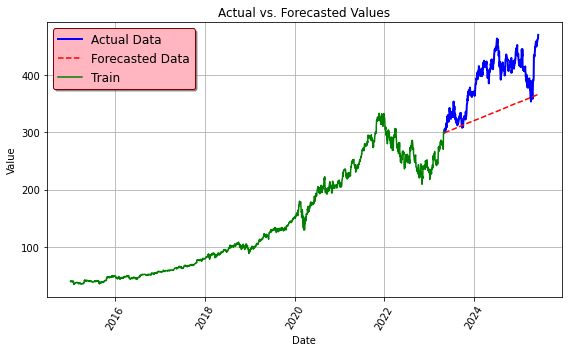

In [102]:
plt.figure(figsize=(8,5))
plt.plot(test_data, label='Actual Data', color='blue', linewidth=2)
plt.plot(fc, label='Forecasted Data', color='red', linestyle='--', linewidth=1.5)
plt.plot(train_data['Close'], label='Train',color='Green')
plt.xticks(rotation=60)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Forecasted Values')

plt.legend(fontsize = 12, shadow=True,facecolor = 'LightPink',edgecolor='maroon')
plt.grid()
plt.tight_layout()
plt.show()

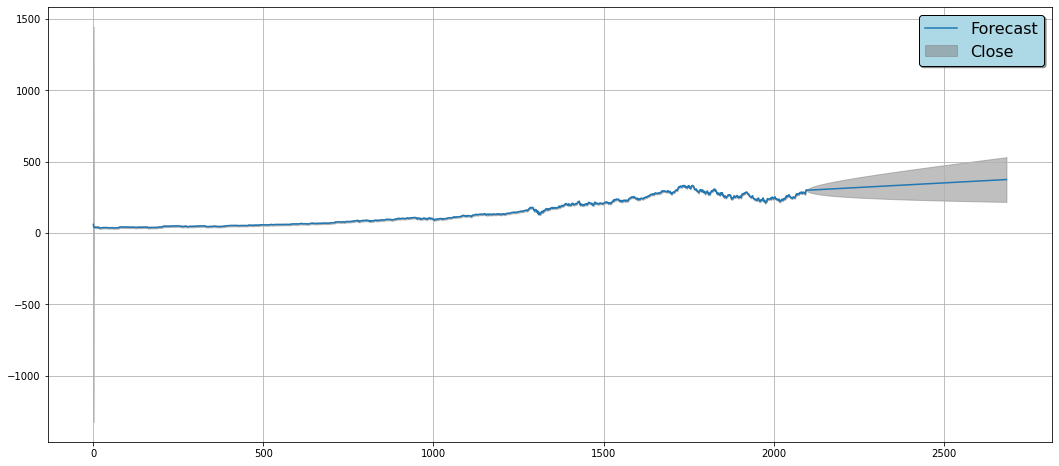

In [103]:
from statsmodels.graphics.tsaplots import plot_predict
plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 1, 1)

plot_predict(result=model_fitted, start=1, end=len(stock_data)+60, ax=ax)
plt.grid()

plt.legend(['Forecast', 'Close', '95% confidence interval'],fontsize=16, shadow=True, facecolor='lightblue', edgecolor='black')

plt.show()


# Sarima Model

In [104]:
# Fit SARIMA model 
model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,30))
model_fit = model.fit()


forecast = model_fit.forecast(steps=525)
forecast.index = test_data.index


In [105]:
rmse = np.sqrt(mean_squared_error(test_data,forecast))
print(rmse)

64.98863314748812


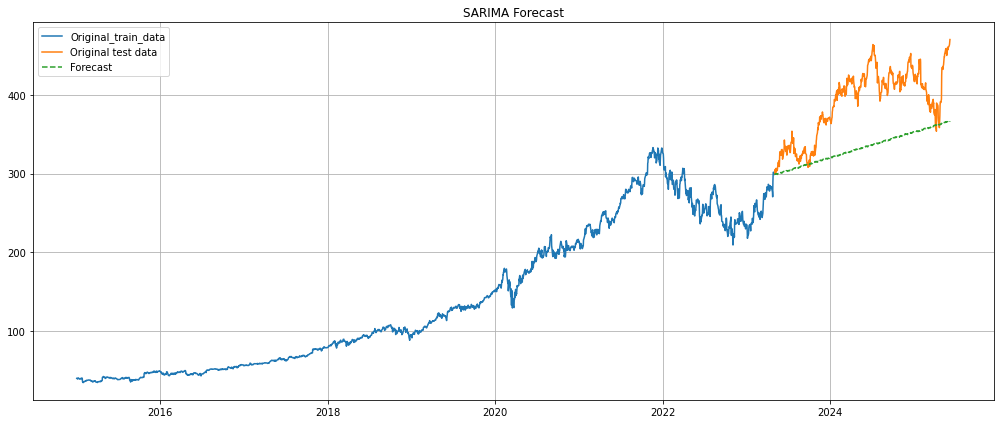

In [106]:

plt.figure(figsize=(14,6))
plt.plot(train_data, label='Original_train_data')
plt.plot(test_data, label='Original test data')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title('SARIMA Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [107]:
# Define endogenous and exogenous variables
y = df['Close']
X = df[['Open', 'High', 'Low', 'Volume']]

# Define train/test split index
split_index = int(len(stock_data) * 0.8)

# Split data
y_train, y_test = y[:split_index], y[split_index:]
X_train, X_test = X[:split_index], X[split_index:]


print(f"Training samples: {len(y_train)}")
print(f"Testing samples: {len(y_test)}")


Training samples: 2098
Testing samples: 525


# SARIMAX model

In [108]:
# Fit SARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
model_fit = model.fit()


In [109]:

forecast = model_fit.forecast(steps=525, exog=X_test)
forecast.index=X_test.index

In [110]:
rmse = np.sqrt(mean_squared_error(y_test,forecast))
print(rmse)

7.535450773570006


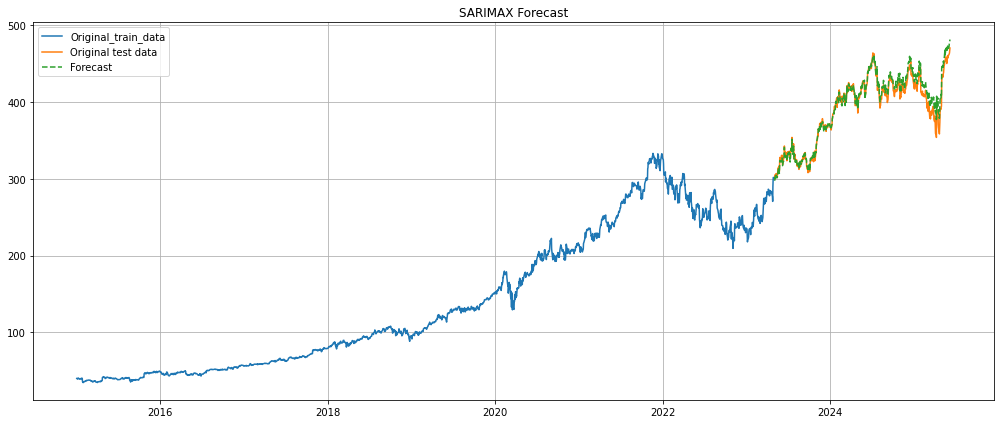

In [111]:
plt.figure(figsize=(14,6))
plt.plot(y_train, label='Original_train_data')
plt.plot(y_test, label='Original test data')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title('SARIMAX Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
